In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_nex_vor = pd.read_csv('data/vor_train/TB_nex_vor_train.csv', parse_dates=['Date'])
df_gmdr_vor = pd.read_csv('data/vor_train/TB_gmdr_vor_train.csv', parse_dates=['Date'])
df_wtgn_vor = pd.read_csv('data/vor_train/TB_wtgn_vor_train.csv', parse_dates=['Date'])

In [3]:
df_nex_vor['study'] = 'NEX'
df_gmdr_vor['study'] = 'GMDR'
df_wtgn_vor['study'] = 'WTGN'

In [4]:
df_vor = pd.concat([df_nex_vor, 
                    df_gmdr_vor, 
                    df_wtgn_vor], axis=0)

In [5]:
df_vor.groupby('Year').count()

,Site,Disturbance,Exclosure,Date,Date_cln,High_cm,Low_cm,Area (m^2),Total Weight (g),Total Weight (g/m^2),...,study,Block,Paddock,Year_clip,Plot_clip,Plot,Pasture,Mean.GPS_E.Biomass,Mean.GPS_N.Biomass,vor_reading_ct
Year,,,,,,,,,,,,,,,,,,,,,
2015.0,2,2,2,2,2,2,2,2,2,2,...,2,0,0,0,0,0,0,0,0,0
2018.0,36,36,36,36,36,36,36,36,36,36,...,36,0,0,0,0,0,0,0,0,0
2019.0,36,36,36,90,36,90,90,36,36,90,...,90,9,9,9,9,45,45,45,45,45
2020.0,29,29,29,82,29,82,82,29,29,82,...,82,10,10,10,10,53,43,43,43,43
2021.0,37,37,37,46,37,46,46,37,37,46,...,46,9,9,9,9,9,0,0,0,0


In [6]:
# remove spaces from column names
for c in df_vor.columns:
    if ' ' in c:
        df_vor.rename(columns={c: re.sub(' ', '_', c)}, inplace=True)

<AxesSubplot:ylabel='Frequency'>

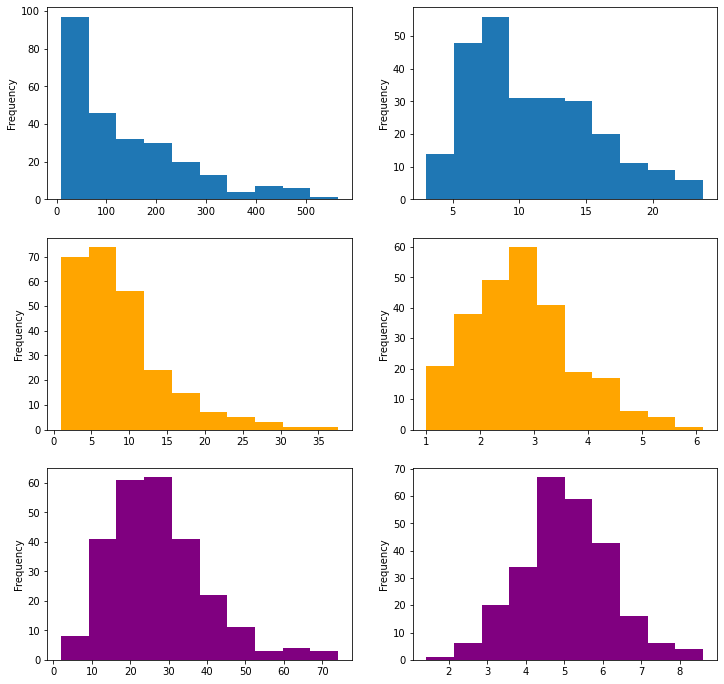

In [7]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 12))
df_vor['Total_Weight_(g/m^2)'].plot.hist(ax=ax[0, 0])
df_vor['Total_Weight_(g/m^2)'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[0, 1])

df_vor['Low_cm'].plot.hist(ax=ax[1, 0], color='orange')
df_vor['Low_cm'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[1, 1], color='orange')

df_vor['High_cm'].plot.hist(ax=ax[2, 0], color='purple')
df_vor['High_cm'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[2, 1], color='purple')
#df_vor['Total_Weight_(g/m^2)'].transform(lambda x: np.log(x)).plot.hist(ax=ax[1])

In [8]:
df_vor['pred_cper'] = (32.9 + 133.6*df_vor['Low_cm'] + 23.7*df_vor['High_cm'])/10
df_vor['resid_cper'] = df_vor['pred_cper'] - df_vor['Total_Weight_(g/m^2)']

In [9]:
df_mod_results = pd.DataFrame(columns=['dataset', 'R2', 
                                       'TB_MAE', 'TB_MAE_pct',
                                       'CPER_MAE', 'CPER_MAE_pct'])

In [10]:
idx=0
for study, grp in df_vor.groupby('study'):
    mod_tmp = smf.ols("Q('Total_Weight_(g/m^2)') ~ Low_cm + High_cm", 
                   data=grp).fit()
    grp['pred_tb'] = mod_tmp.predict()
    grp['resid_tb'] = grp['pred_tb'] - grp['Total_Weight_(g/m^2)']
    mae_tmp = grp.apply(lambda x: abs(x['pred_tb'] - x['Total_Weight_(g/m^2)']), 
                            axis=1).mean()
    mae_tmp_cper = grp.apply(lambda x: abs(x['pred_cper'] - x['Total_Weight_(g/m^2)']), 
                            axis=1).mean()
    df_mod_results = df_mod_results.append(pd.DataFrame({
        'dataset': study,
        'R2': round(mod_tmp.rsquared_adj, 2),
        'TB_MAE': mae_tmp,
        'TB_MAE_pct': round(mae_tmp / grp['Total_Weight_(g/m^2)'].mean() * 100, 2),
        'CPER_MAE': mae_tmp_cper,
        'CPER_MAE_pct': round(mae_tmp_cper / grp['Total_Weight_(g/m^2)'].mean() * 100, 2)},
    index=[idx]))
    idx += 1

In [11]:
df_mod_results

,dataset,R2,TB_MAE,TB_MAE_pct,CPER_MAE,CPER_MAE_pct
0,GMDR,0.56,15.428892,24.70,22.098429,35.38
1,NEX,0.59,67.913606,37.75,78.203540,43.47
2,WTGN,0.58,31.861395,30.97,55.717320,54.15


In [12]:
mod_both = smf.ols("Q('Total_Weight_(g/m^2)') ~ Low_cm + High_cm", 
                   data=df_vor).fit()
df_vor['pred_tb'] = mod_both.predict()
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']

In [13]:
from scipy.stats import shapiro
shapiro(df_vor['resid_tb'])

ShapiroResult(statistic=0.9669896960258484, pvalue=1.2373126082820818e-05)

In [14]:
mod_both.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Q('Total_Weight_(g/m^2)')   R-squared:                       0.637
Model:                                   OLS   Adj. R-squared:                  0.634
Method:                        Least Squares   F-statistic:                     221.9
Date:                       Tue, 19 Jul 2022   Prob (F-statistic):           2.17e-56
Time:                               10:49:23   Log-Likelihood:                -1454.9
No. Observations:                        256   AIC:                             2916.
Df Residuals:                            253   BIC:                             2926.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.4000     11.059     -1.664      0.097     -40.179       3.379
Low_cm        11.9576      1.317      9.076      0.000       9.363      14.552
High_cm        2.0438      0.639      3.197      0.002       0.785       3.303
==============================================================================
Omnibus:                       31.112   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.513
Skew:                           0.658   Prob(JB):                     3.24e-13
Kurtosis:                       4.913   Cond. No.                         77.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
import pickle
with open('models/vor_linreg_both.pk', 'wb') as f:
    pickle.dump(mod_both, f)

### Things to try
* Covariate of precip (try a mixed model first as test)


In [43]:
# relative RMSE
np.sqrt(df_vor.apply(lambda x: np.power(x['pred_tb'] - x['Total_Weight_(g/m^2)'], 
                                2), axis=1).mean()) / df_vor['Total_Weight_(g/m^2)'].mean()

0.5057182846270564

In [42]:
#RMSE
np.sqrt(df_vor.apply(lambda x: np.power(x['pred_tb']*10 - x['Total_Weight_(g/m^2)']*10, 
                                2), axis=1).mean())

710.9935901854582

In [17]:
df_vor.apply(lambda x: abs(x['pred_tb'] - x['Total_Weight_(g/m^2)']), axis=1).mean()

52.181285132230286

In [18]:
np.sqrt(df_vor.apply(lambda x: np.power(x['pred_cper'] - x['Total_Weight_(g/m^2)'], 
                                2), axis=1).mean()) / df_vor['Total_Weight_(g/m^2)'].mean()

0.5959735544305702

In [19]:
df_vor.apply(lambda x: abs(x['pred_cper'] - x['Total_Weight_(g/m^2)']), axis=1).mean()

64.3374051338322

eval_env: 1
eval_env: 1
eval_env: 1


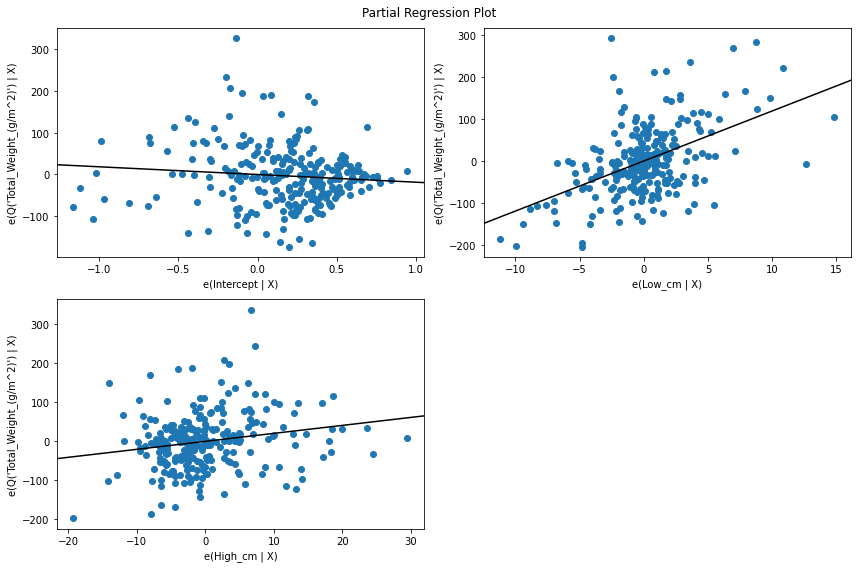

In [20]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_partregress_grid(mod_both, fig=fig)
fig.tight_layout(pad=1.0)

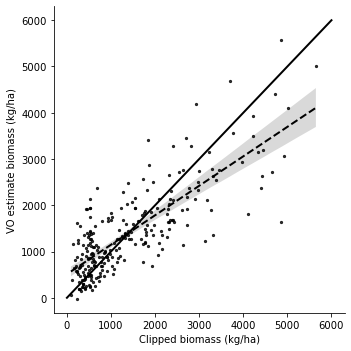

In [40]:
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']
df_vor['pred_tb_kg'] = df_vor['pred_tb']*10
df_vor['Total_Weight_(kg/ha)'] = df_vor['Total_Weight_(g/m^2)']*10
sns.lmplot(y='pred_tb_kg',
           x='Total_Weight_(kg/ha)',
           data=df_vor,
           line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
           scatter_kws={'color': 'black', 's': 5})
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('VO estimate biomass (kg/ha)')
plt.plot([0, 6000], [0, 6000], linewidth=2, c='black', linestyle='solid')

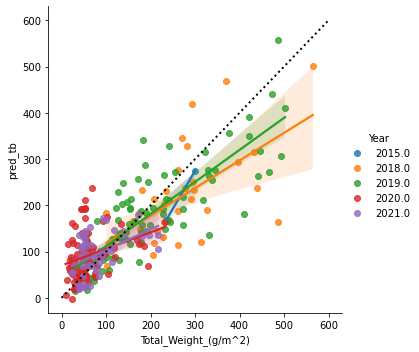

In [44]:
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(y='pred_tb',
           x='Total_Weight_(g/m^2)',
           hue='Year',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

In [47]:
df_vor.columns

Index(['Site', 'Disturbance', 'Exclosure', 'Date', 'Date_cln', 'Year',
       'High_cm', 'Low_cm', 'Area_(m^2)', 'Total_Weight_(g)',
       'Total_Weight_(g/m^2)', 'vor_reading_pct', 'study', 'Block', 'Paddock',
       'Year_clip', 'Plot_clip', 'Plot', 'Pasture', 'Mean.GPS_E.Biomass',
       'Mean.GPS_N.Biomass', 'vor_reading_ct', 'pred_cper', 'resid_cper',
       'pred_tb', 'resid_tb', 'pred_tb_kg', 'Total_Weight_(kg/ha)'],
      dtype='object')

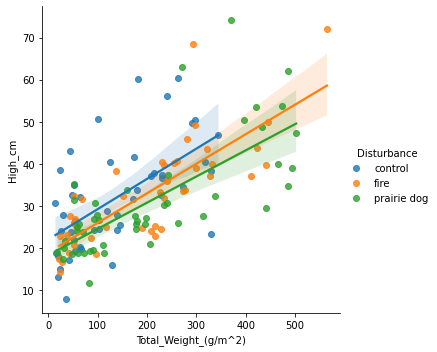

In [52]:
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(y='High_cm',
           x='Total_Weight_(g/m^2)',
           hue='Disturbance',
           data=df_vor)
#plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

### other data
* there is VOR+clipping data from weight gain project, not ready yet (2019 might be ready, not sure about VOR, Elle is weighing 2020 data) - will prioritize 2019/2020 VOR
    * this will be the best VOR/Clipping data
    * 2019 - much of the VOR data won't be usable (but clipping is ok!). Lauren needs to figure out when date cut-off is for fix.
* Courtenay's bird habitat project has a ton of VOR data (30 m transects, since 2015) - can talk with David about this.
    * Clipping done a month later about 8 m away at subset of locations(60-80 locs)
* some other projects from 2014/2015 that Lauren can access
    * This would be nice to expand spatial coverage and burns
* USFS project in 2015/2016 - grid sampliing
    * not sure of their protocol (observations may be too limited)
    * data might be hard to access (a lot of people no longer there)

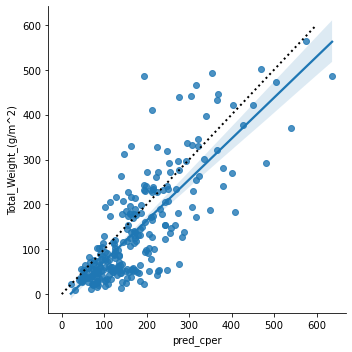

In [23]:
df_vor['pred_cper'] = (32.9 + 133.6*df_vor['Low_cm'] + 23.7*df_vor['High_cm'])/10
df_vor['resid_cper'] = df_vor['pred_cper'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(x='pred_cper',
           y='Total_Weight_(g/m^2)',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

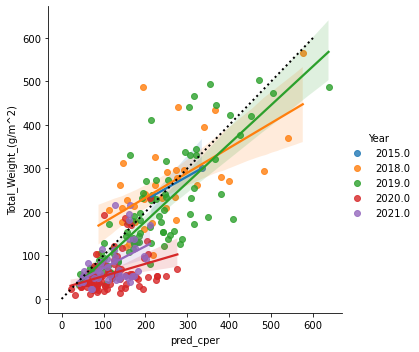

In [24]:
df_vor['pred_cper'] = (32.9 + 133.6*df_vor['Low_cm'] + 23.7*df_vor['High_cm'])/10
df_vor['resid_cper'] = df_vor['pred_cper'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(x='pred_cper',
           y='Total_Weight_(g/m^2)',
           hue='Year',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

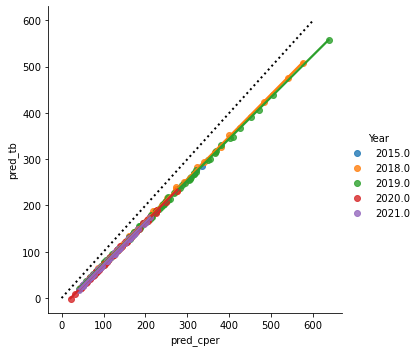

In [25]:
sns.lmplot(x='pred_cper',
           y='pred_tb',
           data=df_vor,
           hue='Year')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

In [26]:
(df_vor['pred_cper'] - df_vor['pred_tb']).max()

79.7160566644427

In [30]:
(df_vor['pred_cper'] - df_vor['pred_tb']).median()

31.423150150934987

In [28]:
(abs(df_vor['pred_cper'] - df_vor['pred_tb'])/df_vor['pred_tb']).mean()

0.2888055042034232